# Determine Forest Cover Types

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Attribute Information - From Dataset Description 


Name / Data Type / Measurement / Description 

Elevation / quantitative /meters / Elevation in meters<br> 
Aspect / quantitative / azimuth / Aspect in degrees azimuth<br> 
Slope / quantitative / degrees / Slope in degrees<br> 
Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features<br> 
Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features<br>
Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway<br> 
Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice<br> 
Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice<br> 
Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice<br> 
Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points<br> 
Wilderness_Area (4 binary columns) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation<br> 
Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation<br> 
Cover_Type (7 types) / integer / 1 to 7 / Forest Cover Type designation<br>

In [2]:
#Names taken from above
wild_area = ['Wilderness_Area_{}'.format(i) for i in range(1,5)]
soil_type = ['Soil_Type_{}'.format(i) for i in range(1,41)]

names = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
        'Horizontal_Distance_To_Roadways','Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
        'Horizontal_Distance_To_Fire_Points']+wild_area + soil_type +['Cover_Type']
data = pd.read_csv('covtype.data', names=names)

data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


## Data Exploration
* Examine class distributions
* Build a baseline classifier
* Explore numerical parameters
* Explore binary parameters
* Explore relationships between numerical and binary parameters

### Class Distribution

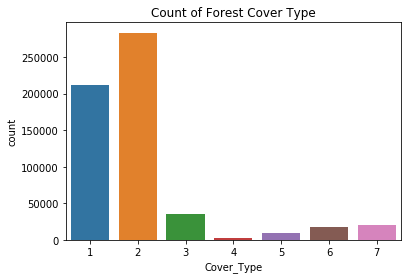

In [3]:
params = data.drop(['Cover_Type'], axis=1)
target = data['Cover_Type']

sns.countplot(data['Cover_Type']);
plt.title('Count of Forest Cover Type');

### Consequences of Above Plot
* Clearly classification accuracy will not be sufficient as the classifier could generate fairly decent results by only learning rules for classifying Forest Cover Types 1 & 2
* Will need to ensure that the testing set has enough examples of Cover Types 3-7.

### Build a Balanced Training Set
* Use `StratifiedShuffleSplit` to retrieve training and testing indices of the data while maintaining original class distributions
* Use `resample` to generate a training set from the training indices that equally represents all cover types. The `test_size` paramter in `StratifiedShuffleSplit` will therefore directly determine the number of Cover Type 4 samples in the training and testing sets.
* Put remaining indices back in test set
* Extract a cross validations set from the test set using `train_test_split`

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

for train_index, test_index in sss.split(params, target):
    train_index, test_index = train_index, test_index
    
#Cover Type 4 is the smallest class and therefore determines the number of samples needed from each class to generate
#a training set with balanced class distribution

n_samples = target.loc[train_index][target==4].count()
print 'Number of samples to be taken from each class:\n{}'.format(n_samples)

Number of samples to be taken from each class:
1373


In [6]:
#Create training set with balanced class distributions

train_indices = []
for i in range(1,8):
    train_indices.extend(resample(target.loc[train_index][target==i], replace=False, n_samples=n_samples, random_state=0).index)


test_add = list(set(train_index).difference(set(train_indices)))
test_index = np.append(test_index, test_add)

#Shuffle indices
np.random.shuffle(train_indices)
np.random.shuffle(test_index)

X_train, y_train = params.loc[train_indices], target.loc[train_indices]
X_test, y_test = params.loc[test_index], target.loc[test_index]

X_validation, X_test, y_validation, y_test = train_test_split(X_test, y_test, test_size=0.9, random_state=0, stratify=y_test)

### Baseline Performance

In [26]:
rfc = RandomForestClassifier(random_state=0)
rfc.fit(X_train, y_train)
print('Accuracy: {:.4f}'.format(rfc.score(X_validation,y_validation)))
print(classification_report(y_validation, rfc.predict(X_validation)))


Accuracy: 0.6914
             precision    recall  f1-score   support

          1       0.69      0.75      0.72     21047
          2       0.84      0.61      0.70     28193
          3       0.75      0.78      0.76      3438
          4       0.32      0.96      0.48       137
          5       0.20      0.91      0.33       812
          6       0.48      0.78      0.60      1599
          7       0.52      0.94      0.67      1914

avg / total       0.75      0.69      0.70     57140



### Feature Importances
* Look at feature importances for `RandomForestClassifier` and get baseline performance using top 10 and top 20 features

In [24]:
feature_importances = pd.DataFrame(rfc.feature_importances_, 
                                   index = X_train.columns, 
                                   columns=['importance']).sort_values('importance', ascending=False)
#Only display top 20 features
feature_importances.iloc[:20]

#pd.set_option('display.float_format', lambda x: '%.3f' % x)

,importance
Elevation,0.178650
Horizontal_Distance_To_Roadways,0.100870
Horizontal_Distance_To_Fire_Points,0.070991
Horizontal_Distance_To_Hydrology,0.064672
Hillshade_9am,0.055275
Aspect,0.052146
Wilderness_Area_4,0.050790
Hillshade_Noon,0.049903
Vertical_Distance_To_Hydrology,0.049862
Hillshade_3pm,0.044848


In [36]:
X_train_10 = X_train[np.array(feature_importances[:10].index)]
X_validation_10 = X_validation[np.array(feature_importances[:10].index)]

X_train_20 = X_train[np.array(feature_importances[:20].index)]
X_validation_20 = X_validation[np.array(feature_importances[:20].index)]

rfc.fit(X_train_10, y_train)
print('Results for top 10 features\nAccuracy: {:.4f}\n{}'.format(rfc.score(X_validation_10, y_validation),
                                                                 classification_report(y_validation, rfc.predict(X_validation_10))))

rfc.fit(X_train_20,y_train)
print('Results for top 20 features\nAccuracy: {:.4f}\n{}'.format(rfc.score(X_validation_20, y_validation),
                                                                 classification_report(y_validation, rfc.predict(X_validation_20))))


Results for top 10 features
Accuracy: 0.6444
             precision    recall  f1-score   support

          1       0.67      0.71      0.69     21047
          2       0.82      0.55      0.66     28193
          3       0.68      0.76      0.71      3438
          4       0.32      0.92      0.47       137
          5       0.17      0.90      0.28       812
          6       0.41      0.77      0.53      1599
          7       0.41      0.93      0.57      1914

avg / total       0.72      0.64      0.66     57140

Results for top 20 features
Accuracy: 0.6813
             precision    recall  f1-score   support

          1       0.68      0.75      0.71     21047
          2       0.84      0.59      0.69     28193
          3       0.75      0.76      0.76      3438
          4       0.32      0.92      0.47       137
          5       0.20      0.91      0.33       812
          6       0.44      0.78      0.56      1599
          7       0.49      0.95      0.65      1914

avg 

### Results of Baseline Classification
* Top 10 most important features - accuracy drops by 4 percentage points
* Top 20 most important features - accuracy drops by 1 percentage point
* The top 20 features plus any engineered features and the complete dataset will be compared, if excellent results are obtained with the top 20 features the top 10 plus engineered features will be used

### Explore Numerical Variables

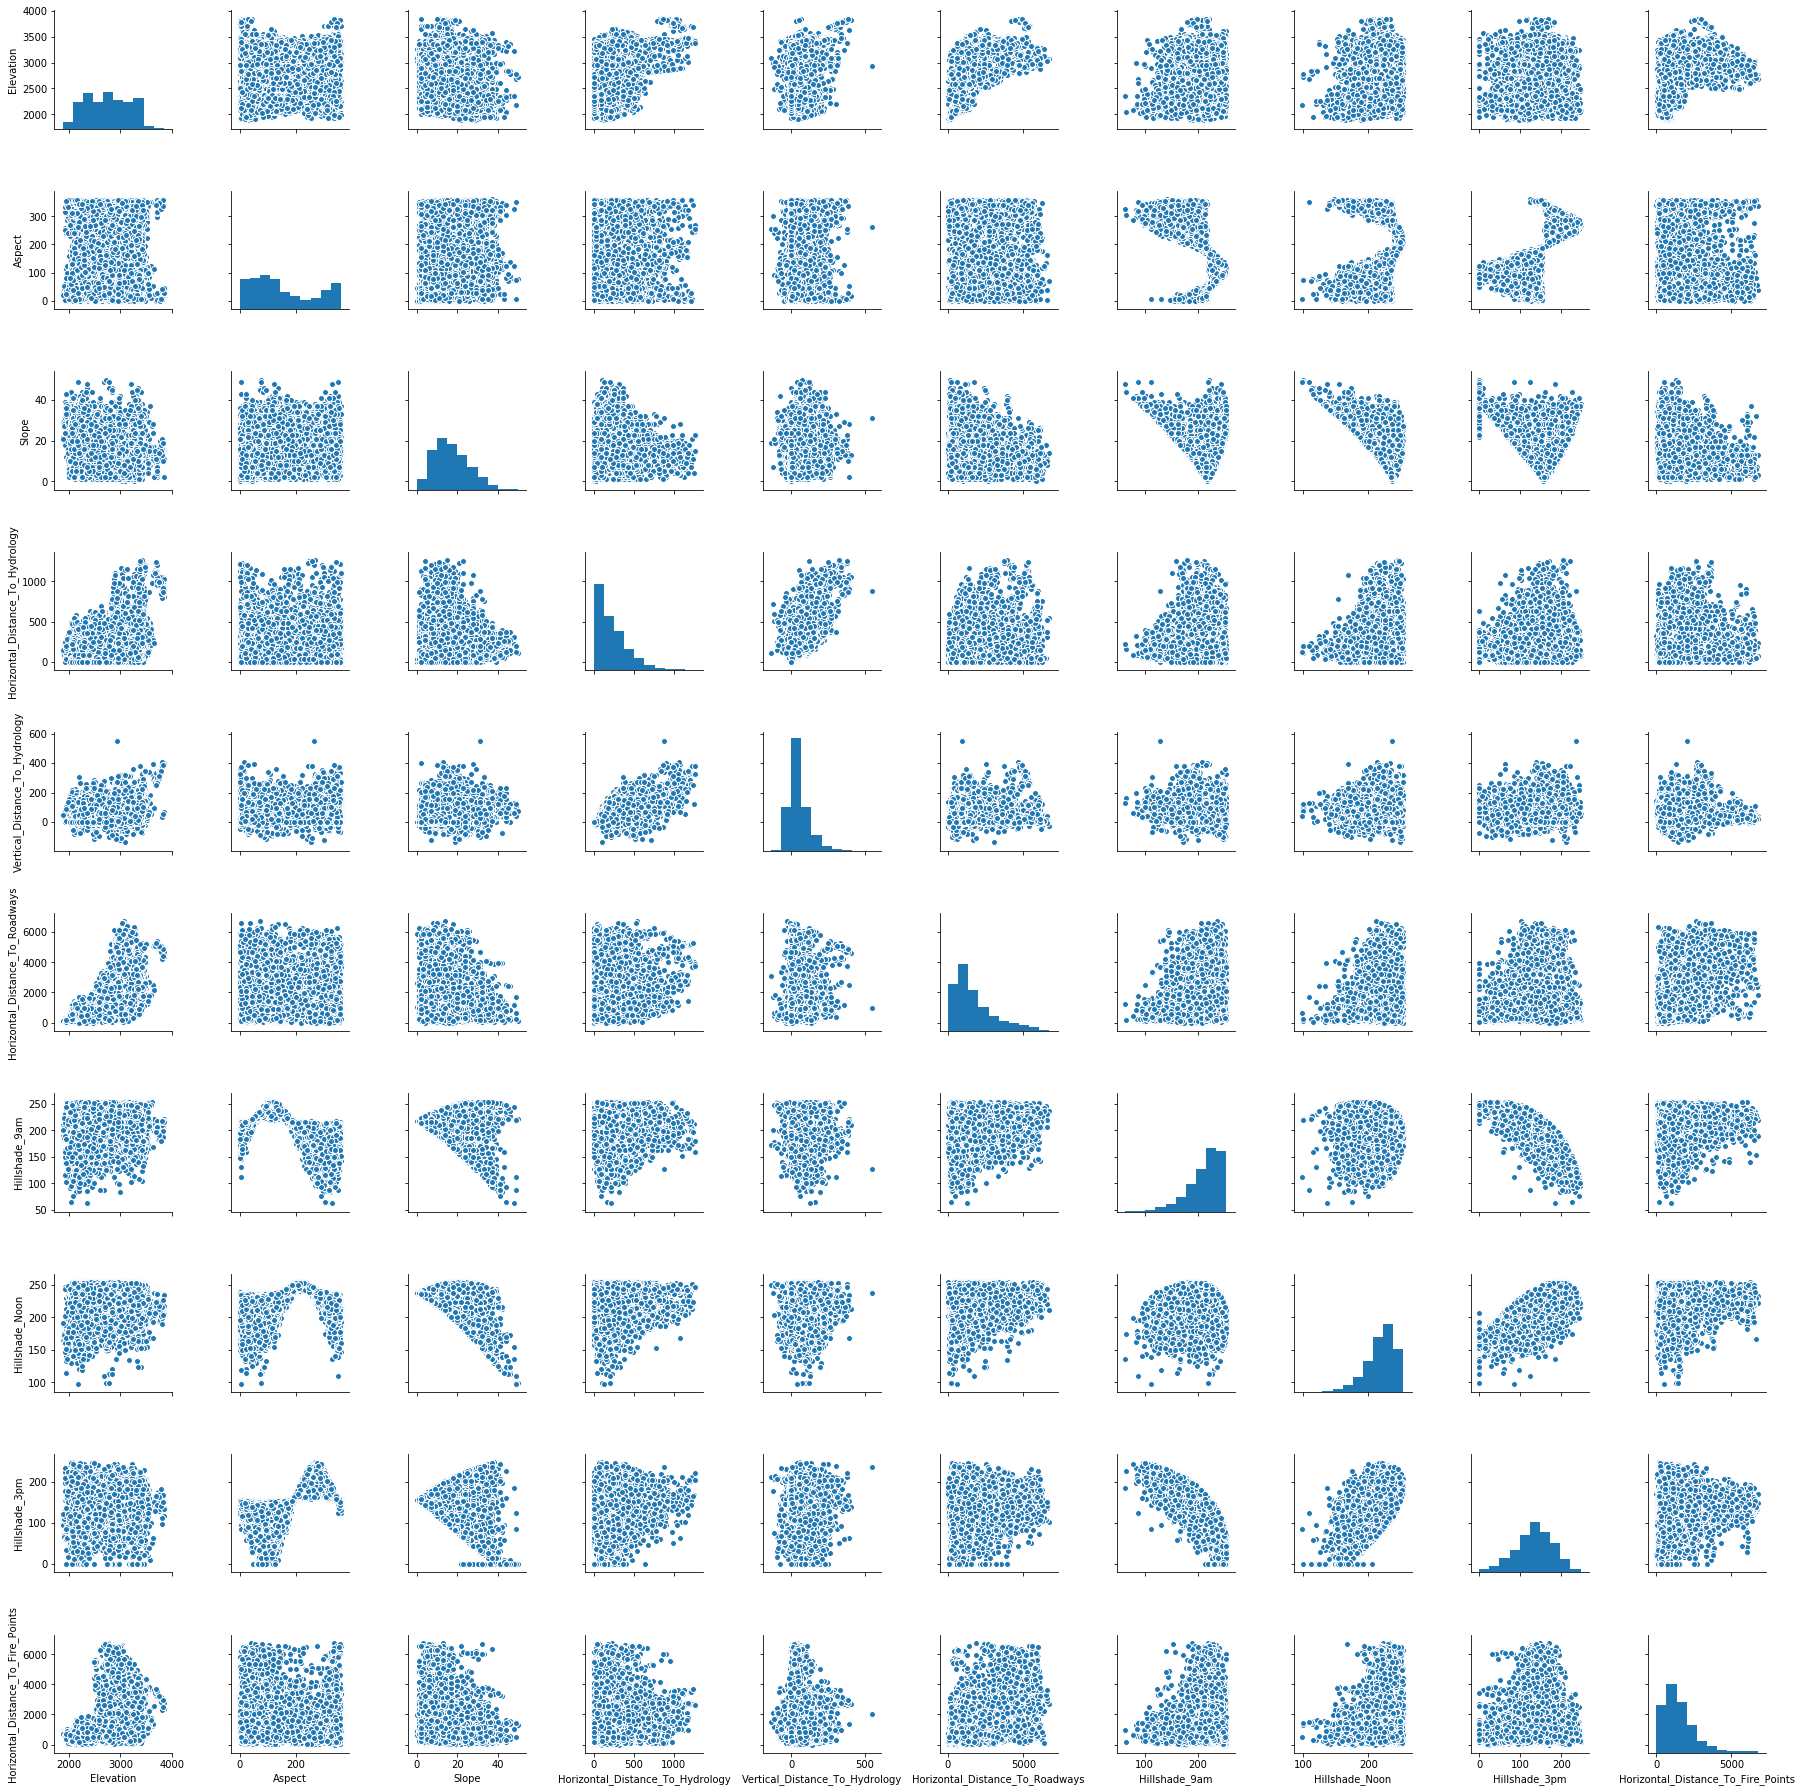

In [44]:
#Separate numerical and binary parameters so they can be examined
numerical_params = X_train.drop(soil_type+wild_area, axis=1)
binary_params = X_train[soil_type+wild_area]

sns.pairplot(numerical_params);

### Examine Aspect, Slope, and Hillshade features in more detail

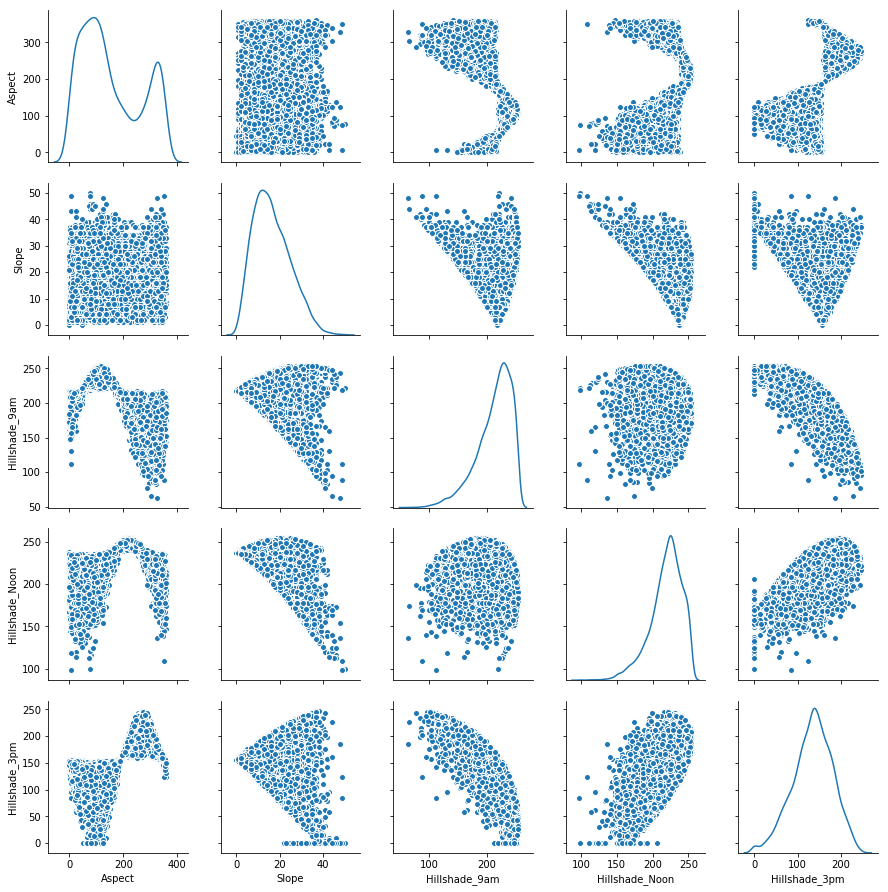

In [16]:
sns.pairplot(X_train[['Aspect', 'Slope', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']], diag_kind='kde')

### Explore Distance Related Features in Detail

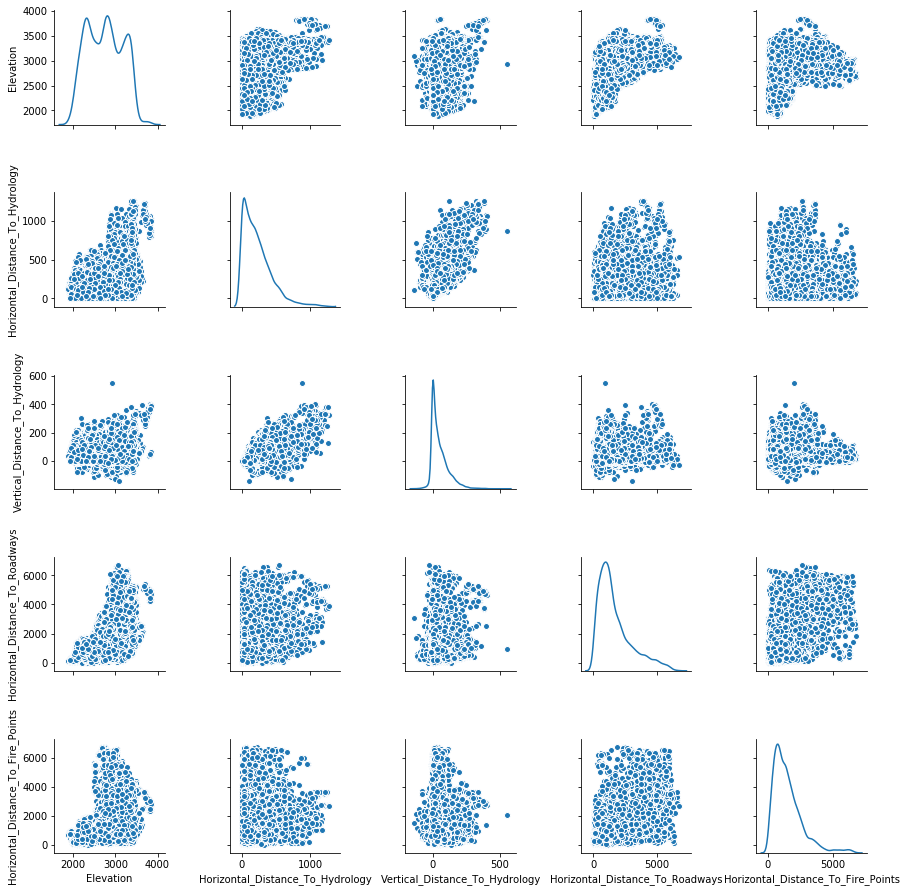

In [37]:
sns.pairplot(X_train[['Elevation', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
                      'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']], diag_kind='kde');